In [ ]:
import librosa
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import glob
import os
import warnings
from bokeh.io import export_svgs, output_notebook
from bokeh.models import BoxAnnotation, ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
# from utils.measuring_performance import (
#     get_prediction,
#     plot_confusion_matrix,
#     plot_histogram_by_class,
#     plot_loss_per_epoch,
#     plot_pr_curve,
#     plot_roc_curve,
# )
# from utils.misc import build_files_list, dump_pickle, load_pickle
# from utils.sound_utils import extract_signal_features, generate_dataset, load_sound_file

output_notebook()
warnings.filterwarnings("ignore")
np.random.seed(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/drive/MyDrive/HSE/CEPR_data/'
filenames = os.listdir(DATA_DIR)

In [ ]:
!ls $DATA_DIR

'20161129_dmc 63  шпиндель 1000 до 12000_000.csv'
 20161129_micro_uccp_600_шпиндель_разгон_1000_до_18000.csv
 20161130_dmu_50_разгон_шпинделя_1000_6000_000.csv
 20161130_wilemin_518s_разгон_шпинделя_с_1000_3000_18000_000.csv
 20161201_okuma_multus_b300w_фрезерный_шпиндель_1000_3000_000.csv
'20170727_шпиндель dmc 835v шпиндель_001.csv'
'20171031_huron spindel 1000-8000_000.csv'
'20171031_mikron spindel 1000-10000_000.csv'
'20171101_tajmac zps mcfv 1680  2 spindel 500-2500_000.csv'
'20171101_tajmac zps mcfv 1680  spindel  500-3000_000.csv'
'20171114_dmu 70 шпиндель_000.csv'
'20171114_dmu 70 шпиндель_001.csv'
 20180111_шпиндель_002.csv
'20211019_211019_DMU40 Monoblock_spindle_1000-10000_000.csv'
'dmc 635 v 55 шпиндель_20230405_000.csv'
'dmc 635V ecoline шпиндел новый_20230405_000.csv'
'dmc 635V ecoline шпиндел новый_20230405_001.csv'
 dmg_dmu_50_Ecoline_1_шпиндель_1000_12000_20211124_000.csv
 dmg_dmu_50_Ecoline_2_шпиндель_1000_12000_20211124_000.csv
 dmg_dmu_50_Ecoline_3_шпиндель_1000_

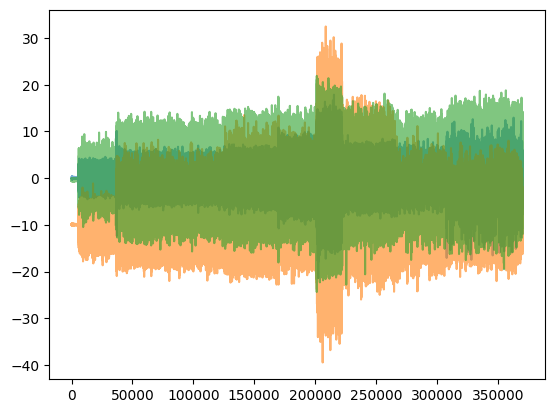

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pd.read_csv(DATA_DIR+'./20161129_dmc 63  шпиндель 1000 до 12000_000.csv').values.squeeze(), alpha=0.6);

In [ ]:
from sklearn.model_selection import train_test_split

labels = [3,0,0,0,0,0,0,1,0,1,1,0,3,3,1,0,0,0,1,2,1,3,2,3,1,1,3,3,2,2,1,2,3,3,3,2,3]
filenames_train, filenames_test, labels_train, labels_test = train_test_split(filenames, labels, test_size=4, stratify=labels)

for filename, label in zip(filenames, labels):
  print(filename, np.percentile(np.abs(pd.read_csv(f'{DATA_DIR}/{filename}').values.squeeze()), 90, axis=0), label)

20161129_dmc 63  шпиндель 1000 до 12000_000.csv [ 4.45 14.11  8.94] 3
20161129_micro_uccp_600_шпиндель_разгон_1000_до_18000.csv [9.94 0.52 0.89] 0
20171031_huron spindel 1000-8000_000.csv [ 1.78 10.06  5.4 ] 0
20161201_okuma_multus_b300w_фрезерный_шпиндель_1000_3000_000.csv [5.86 2.39 8.82] 0
20161130_dmu_50_разгон_шпинделя_1000_6000_000.csv [0.8  0.37 9.94] 0
20171031_mikron spindel 1000-10000_000.csv [0.49 2.62 9.51] 0
20170727_шпиндель dmc 835v шпиндель_001.csv [0.63 0.6  9.89] 0
20171101_tajmac zps mcfv 1680  2 spindel 500-2500_000.csv [1.09 2.24 9.94] 1
20161130_wilemin_518s_разгон_шпинделя_с_1000_3000_18000_000.csv [ 1.49  1.01 10.06] 0
20171101_tajmac zps mcfv 1680  spindel  500-3000_000.csv [0.6  0.75 9.8 ] 1
20180111_шпиндель_002.csv [11.41  1.84  0.95] 1
dmc 635V ecoline шпиндел новый_20230405_001.csv [ 1.21  0.8  10.09] 0
20171114_dmu 70 шпиндель_000.csv [2.01 2.06 3.44] 3
dmc 635 v 55 шпиндель_20230405_000.csv [ 9.69  8.74 13.71] 3
20211019_211019_DMU40 Monoblock_spindle_

In [ ]:
# Построить распределения по классам
from collections import defaultdict
label_values_train, label_values_test = defaultdict(list), defaultdict(list)
for label_values, filenames, labels in zip([label_values_train, label_values_test],
 [filenames_train, filenames_test],
  [labels_train, labels_test]):
  for label in [0,1,2,3]:
    label_filenames = [f for f, l in zip(filenames, labels) if l==label]
    for filename in label_filenames:
      values = np.abs(pd.read_csv(f'{DATA_DIR}/{filename}').values.squeeze())
      label_values[label].append(values)
# label_values = {k:np.concatenate(v) for k,v in label_values.items()}

# Dataset generation

In [ ]:
def feature_fn(vals, phase, percentile):
  return np.percentile(vals[:,phase], percentile)

feature_fns = []
for phase in range(3):
  for percentile in range(0,100,10):
    args = (phase,percentile)
    feature_fns.append((feature_fn, args))

In [ ]:
from tqdm.auto import tqdm
N_SAMPLES_TRAIN = 100000
N_SAMPLES_TEST = int(0.1*N_SAMPLES_TRAIN)
SAMPLE_SIZE = 1000

X_train, y_train, X_test, y_test = [], [], [], []

for X,y,label_values,n_samples in zip([X_train, X_test],
 [y_train, y_test],
 [label_values_train, label_values_test],
 [N_SAMPLES_TRAIN, N_SAMPLES_TEST]):
  for _ in tqdm(range(n_samples)):
    label = np.random.choice([0,1,2,3])
    files = label_values[label]
    file_values = files[np.random.choice(np.arange(len(files)))]
    sample_indices = np.random.choice(np.arange(file_values.shape[0]), SAMPLE_SIZE)
    samples = file_values[sample_indices]
    y.append(label)
    x = []
    for fn, args in feature_fns:
      x.append(fn(samples, *args))
    X.append(x)

X_train, y_train, X_test, y_test = [np.array(x) for x in [X_train, y_train, X_test, y_test]]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
X_train.shape, X_test.shape

((100000, 30), (10000, 30))

In [ ]:
from xgboost import XGBClassifier
# read data
# create model instance
bst = XGBClassifier()
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

In [ ]:
np.mean(y_test == preds)

0.4985

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)


    pred = clf.predict(X_test)
    accuracy = np.mean(pred==y_test)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.4565
SCORE:
0.1001
SCORE:
0.2041
SCORE:
0.4096
SCORE:
0.4589
SCORE:
0.2057
SCORE:
0.4107
SCORE:
0.4586
SCORE:
0.4557
SCORE:
0.4268
SCORE:
0.4939
SCORE:
0.4391
SCORE:
0.2049
SCORE:
0.4594
SCORE:
0.4306
SCORE:
0.2019
SCORE:
0.4549
SCORE:
0.4576
SCORE:
0.4546
SCORE:
0.4581
SCORE:
0.462
SCORE:
0.2573
SCORE:
0.4547
SCORE:
0.4641
SCORE:
0.4774
SCORE:
0.4787
SCORE:
0.2573
SCORE:
0.4834
SCORE:
0.1621
SCORE:
0.4964
SCORE:
0.5157
SCORE:
0.5068
SCORE:
0.4433
SCORE:
0.4524
SCORE:
0.4294
SCORE:
0.4582
SCORE:
0.4562
SCORE:
0.4436
SCORE:
0.4599
SCORE:
0.452
SCORE:
0.5014
SCORE:
0.4442
SCORE:
0.4582
SCORE:
0.4314
SCORE:
0.4406
SCORE:
0.4534
SCORE:
0.4515
SCORE:
0.4613
SCORE:
0.4606
SCORE:
0.4321
SCORE:
0.5074
SCORE:
0.4563
SCORE:
0.4596
SCORE:
0.4542
SCORE:
0.1014
SCORE:
0.4618
SCORE:
0.4562
SCORE:
0.1347
SCORE:
0.4562
SCORE:
0.4256
SCORE:
0.471
SCORE:
0.4609
SCORE:
0.4667
SCORE:
0.4578
SCORE:
0.4982
SCORE:
0.4396
SCORE:
0.4391
SCORE:
0.4592
SCORE:
0.4557
SCORE:
0.46
SCORE:
0.447
SCORE:
0.455

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8196196018079095, 'gamma': 1.6539151559163618, 'max_depth': 18.0, 'min_child_weight': 0.0, 'reg_alpha': 43.0, 'reg_lambda': 0.5023457239213882}


In [ ]:
best_hyperparams

{'colsample_bytree': 0.8196196018079095,
 'gamma': 1.6539151559163618,
 'max_depth': 18.0,
 'min_child_weight': 0.0,
 'reg_alpha': 43.0,
 'reg_lambda': 0.5023457239213882}

In [ ]:
for k,v in best_hyperparams.items():
  if v == int(v):
    best_hyperparams[k] = int(v)
bst = XGBClassifier(**best_hyperparams)
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)
np.mean(preds==y_test)

0.4985

In [ ]:
set(preds)

{0, 3}

In [ ]:
y_test

array([2, 0, 2, ..., 3, 2, 0])

In [ ]:
np.mean(preds[y_test==3])

3.0

In [ ]:
DATA_DIR

'/content/drive/MyDrive/HSE/CEPR_data/'

In [ ]:
import pickle
with open('/content/drive/MyDrive/HSE/CEPR_model_xgb.pkl', 'wb') as f:
  pickle.dump(bst, f)